Table of contents:

* [External Data](#first)

* [More Models](#second)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
import xgboost as xgb
import sklearn
import shap

In [3]:
from sklearn.preprocessing import StandardScaler

In [27]:
from pycaret.regression import *

In [4]:
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (12,6)

In [5]:
X_train = pd.read_excel('data/X_train_feat_eng.xlsx', index_col=0)
y_train = pd.read_excel('data/y_train_feat_eng.xlsx', index_col=0)
X_test = pd.read_excel('data/X_test_feat_eng.xlsx', index_col=0)
y_test = pd.read_excel('data/y_test_feat_eng.xlsx', index_col=0)

In [6]:
X_train['company'] = X_train['company'].astype('category')
X_test['company'] = X_test['company'].astype('category')

In [7]:
def smape(y_true, y_pred, order=2):
    if not isinstance(y_true, np.ndarray):
        y_true = np.asarray(y_true)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.linalg.norm(y_true-y_pred, ord=order))/(np.linalg.norm(y_true, ord=order)+np.linalg.norm(y_pred, ord=order))

# <a name=first> </a> External Data

## Loading

### CPI

In [9]:
cpi = pd.read_excel('data/external_data/cpi.xls', header=10)
cpi.columns = ['date', 'cpi']
cpi['date'] = pd.to_datetime(cpi['date'])
#cpi.set_index('date', inplace=True)

In [10]:
cpi['month'] = cpi['date'].dt.month
cpi['year'] = cpi['date'].dt.year

In [11]:
cpi_train = [cpi[(cpi['month'] == month) & (cpi['year'] == year)]['cpi'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
cpi_test = [cpi[(cpi['month'] == month) & (cpi['year'] == year)]['cpi'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [12]:
X_train['CPI'] = cpi_train
X_test['CPI'] = cpi_test

### PPI

In [13]:
ppi = pd.read_excel('data/external_data/ppi.xls', header=10)
ppi.columns = ['date', 'ppi']
ppi['date'] = pd.to_datetime(ppi['date'])
ppi['month'] = ppi['date'].dt.month
ppi['year'] = ppi['date'].dt.year

In [14]:
ppi_train = [ppi[(ppi['month'] == month) & (ppi['year'] == year)]['ppi'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
ppi_test = [ppi[(ppi['month'] == month) & (ppi['year'] == year)]['ppi'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [15]:
X_train['PPI'] = ppi_train
X_test['PPI'] = ppi_test

### FED funds rate

In [16]:
fed_rate = pd.read_excel('data/external_data/fed_rate.xls', header=10)
fed_rate.columns = ['date', 'fed_rate']
fed_rate['date'] = pd.to_datetime(fed_rate['date'])
fed_rate['month'] = fed_rate['date'].dt.month
fed_rate['year'] = fed_rate['date'].dt.year

In [17]:
fed_rate_train = [fed_rate[(fed_rate['month'] == month) & (fed_rate['year'] == year)]['fed_rate'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
fed_rate_test = [fed_rate[(fed_rate['month'] == month) & (fed_rate['year'] == year)]['fed_rate'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [18]:
X_train['FED_RATE'] = fed_rate_train
X_test['FED_RATE'] = fed_rate_test

### Real earings

In [19]:
wage = pd.read_excel('data/external_data/real_wage.xls', header=10)
wage.columns = ['date', 'wage']
wage['date'] = pd.to_datetime(wage['date'])
wage['month'] = wage['date'].dt.month
wage['year'] = wage['date'].dt.year

In [20]:
months = [x for x in range(1, 13)]*20
years = []
for i in range(2003,2023):
    years += [i]*12
wage = pd.merge(left=wage, right=pd.DataFrame({'month': months, 'year': years}), how='right', on=['month', 'year'])
wage = wage.fillna(method='ffill')

In [21]:
wage_train = [wage[(wage['month'] == month) & (wage['year'] == year)]['wage'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
wage_test = [wage[(wage['month'] == month) & (wage['year'] == year)]['wage'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [22]:
X_train['WAGE'] = fed_rate_train
X_test['WAGE'] = fed_rate_test

### Unemployment

In [23]:
unemp = pd.read_excel('data/external_data/UNRATE.xls', header=10)
unemp.columns = ['date', 'unemp']
unemp['date'] = pd.to_datetime(unemp['date'])
unemp['month'] = unemp['date'].dt.month
unemp['year'] = unemp['date'].dt.year

In [24]:
unemp_train = [unemp[(unemp['month'] == month) & (unemp['year'] == year)]['unemp'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
unemp_test = [unemp[(unemp['month'] == month) & (unemp['year'] == year)]['unemp'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [25]:
X_train['UNEMP'] = fed_rate_train
X_test['UNEMP'] = fed_rate_test

### WTI

In [26]:
wti = pd.read_excel('data/external_data/WTI.xls', header=10)
wti.columns = ['date', 'wti']
wti['date'] = pd.to_datetime(wti['date'])
wti['month'] = wti['date'].dt.month
wti['year'] = wti['date'].dt.year

In [27]:
wti_train = [wti[(wti['month'] == month) & (wti['year'] == year)]['wti'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
wti_test = [wti[(wti['month'] == month) & (wti['year'] == year)]['wti'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [28]:
X_train['WTI'] = wti_train
X_test['WTI'] = wti_test

### Industrial Production

In [29]:
indprod = pd.read_excel('data/external_data/INDPRO.xls', header=10)
indprod.columns = ['date', 'indprod']
indprod['date'] = pd.to_datetime(indprod['date'])
indprod['month'] = indprod['date'].dt.month
indprod['year'] = indprod['date'].dt.year

In [30]:
indprod_train = [indprod[(indprod['month'] == month) & (indprod['year'] == year)]['indprod'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
indprod_test = [indprod[(indprod['month'] == month) & (indprod['year'] == year)]['indprod'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [31]:
X_train['indprod'] = indprod_train
X_test['indprod'] = indprod_test

### GDP

In [32]:
gdp = pd.read_excel('data/external_data/GDP.xls', header=10)
gdp.columns = ['date', 'gdp']
gdp['date'] = pd.to_datetime(gdp['date'])
gdp['month'] = gdp['date'].dt.month
gdp['year'] = gdp['date'].dt.year

In [33]:
months = [x for x in range(1, 13)]*20
years = []
for i in range(2003,2023):
    years += [i]*12
gdp = pd.merge(left=gdp, right=pd.DataFrame({'month': months, 'year': years}), how='right', on=['month', 'year'])
gdp = gdp.fillna(method='ffill')

In [34]:
gdp_train = [gdp[(gdp['month'] == month) & (gdp['year'] == year)]['gdp'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
gdp_test = [gdp[(gdp['month'] == month) & (gdp['year'] == year)]['gdp'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [35]:
X_train['gdp'] = fed_rate_train
X_test['gdp'] = fed_rate_test

### Oil production

In [36]:
oilprod = pd.read_excel('data/external_data/OILPROD.xls', header=10)
oilprod.columns = ['date', 'oilprod']
oilprod['date'] = pd.to_datetime(oilprod['date'])
oilprod['month'] = oilprod['date'].dt.month
oilprod['year'] = oilprod['date'].dt.year

In [37]:
months = [x for x in range(1, 13)]*20
years = []
for i in range(2003,2023):
    years += [i]*12
oilprod = pd.merge(left=oilprod, right=pd.DataFrame({'month': months, 'year': years}), how='right', on=['month', 'year'])
oilprod = oilprod.fillna(method='ffill')

In [38]:
oilprod_train = [oilprod[(oilprod['month'] == month) & (oilprod['year'] == year)]['oilprod'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
oilprod_test = [oilprod[(oilprod['month'] == month) & (oilprod['year'] == year)]['oilprod'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [39]:
X_train['oilprod'] = oilprod_train
X_test['oilprod'] = oilprod_test

### Oil extraction

In [40]:
oilextr = pd.read_excel('data/external_data/OILEXTR.xls', header=10)
oilextr.columns = ['date', 'oilextr']
oilextr['date'] = pd.to_datetime(oilextr['date'])
oilextr['month'] = oilextr['date'].dt.month
oilextr['year'] = oilextr['date'].dt.year

In [41]:
oilextr_train = [oilextr[(oilextr['month'] == month) & (oilextr['year'] == year)]['oilextr'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
oilextr_test = [oilextr[(oilextr['month'] == month) & (oilextr['year'] == year)]['oilextr'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [42]:
X_train['oilextr'] = oilextr_train
X_test['oilextr'] = oilextr_test

### S&P500 index

In [43]:
import yfinance as yf

In [44]:
sp500 = yf.download('SPY', start='2004-02-01', end='2022-12-01')

[*********************100%***********************]  1 of 1 completed


In [45]:
sp500.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
sp500.reset_index(inplace=True)

In [46]:
sp500.columns = ['date', 'sp500']
sp500['date'] = pd.to_datetime(sp500['date'])
sp500['month'] = sp500['date'].dt.month
sp500['year'] = sp500['date'].dt.year

In [47]:
sp500_train = [sp500[(sp500['month'] == month) & (sp500['year'] == year)]['sp500'].values[0] for month, year in zip(X_train.index.month, X_train.index.year)]
sp500_test = [sp500[(sp500['month'] == month) & (sp500['year'] == year)]['sp500'].values[0] for month, year in zip(X_test.index.month, X_test.index.year)]

In [48]:
X_train['sp500'] = sp500_train
X_test['sp500'] = sp500_test

In [51]:
X_train.to_excel('data/X_train_extern.xlsx')
X_test.to_excel('data/X_test_extern.xlsx')

## Usage

In [8]:
X_train = pd.read_excel('data/X_train_extern.xlsx', index_col=0)
X_test = pd.read_excel('data/X_test_extern.xlsx', index_col=0)

In [10]:
ext_features = ['CPI', 'PPI', 'FED_RATE', 'WAGE', 'UNEMP', 'WTI', 'indprod', 'gdp', 'oilprod', 'oilextr', 'sp500']

In [11]:
X_train[ext_features]

,CPI,PPI,FED_RATE,WAGE,UNEMP,WTI,indprod,gdp,oilprod,oilextr,sp500
date,,,,,,,,,,,
2011-12-31,-0.246652,199.8,0.07,0.07,0.07,100.20,96.2147,0.07,92.1209,267.7,124.970001
2012-03-31,0.759456,204.2,0.13,0.13,0.13,108.76,96.5973,0.13,96.2302,259.7,137.729996
2012-06-30,-0.146640,199.8,0.16,0.16,0.16,83.17,97.4903,0.16,97.9508,208.4,128.160004
2012-09-30,0.446221,204.4,0.14,0.14,0.14,0.00,97.2405,0.14,101.8652,242.8,141.029999
2012-12-31,-0.269306,201.5,0.16,0.16,0.16,88.69,98.2061,0.16,108.4029,242.6,141.449997
...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,0.019915,200.3,2.38,2.38,2.38,53.25,102.5928,2.38,187.6951,128.8,274.570007
2019-09-30,0.078345,198.4,2.04,2.04,2.04,0.00,102.5790,2.04,191.5446,131.2,290.739990
2019-12-31,-0.090977,199.0,1.55,1.55,1.55,55.97,101.7632,1.55,195.3964,139.0,311.640015


In [22]:
X_train.company = X_train.company.astype('category')
X_test.company = X_test.company.astype('category')

In [23]:
xgb_params = {'reg_lambda': 2,
 'reg_alpha': 0,
 'max_depth': 5,
 'learning_rate': 0.4,
 'gamma': 0.05,
 'tree_method': 'hist',
 'seed': 42}

In [24]:
scalerX = StandardScaler().fit(X_train.loc[:,~X_train.columns.isin(['company'])])
train_for_scale = X_train.loc[:,~X_train.columns.isin(['company'])]
test_for_scale = X_test.loc[:,~X_test.columns.isin(['company'])]
X_train_scaled = pd.DataFrame(scalerX.transform(train_for_scale), index=train_for_scale.index, columns=train_for_scale.columns)
X_test_scaled = pd.DataFrame(scalerX.transform(test_for_scale), index=test_for_scale.index, columns=test_for_scale.columns)
X_train_scaled = pd.concat([X_train_scaled, X_train['company']], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test['company']], axis=1)

In [25]:
Xy_train_d = xgb.DMatrix(X_train_scaled, y_train, enable_categorical=True)
X_test_d = xgb.DMatrix(X_test_scaled, enable_categorical=True)
booster = xgb.train(xgb_params, Xy_train_d, num_boost_round=100,
                    custom_metric=smape, maximize=False)

In [26]:
X_test_d = xgb.DMatrix(X_test_scaled, enable_categorical=True)
preds = booster.predict(X_test_d)
smape(y_test, preds)

32.86212535444896

Our score has improved!

# <a name=second> </a> More models

## Pycaret

In [28]:
target = list(y_train.columns)
data_train = pd.concat([X_train, y_train], axis=1)

In [29]:
num_features = data_train.columns[~data_train.columns.isin(target+['company'])]

In [30]:
final_model = {}
all_results = []

In [31]:
for i, t in enumerate(target):
    # initialize setup from pycaret.regression
    s = setup(data_train.reset_index(drop=True),
              target = t, train_size = 0.95,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              normalize=True,
              ignore_features = [target[(i+1)%2]],
              numeric_features = list(num_features),
              categorical_features = ['company'],
              silent = True, verbose = False, session_id = 123)
    
    # compare all models and select best one based on RMSE 
    # (because we use SMAPE for multivariate dependent variable)
    best_model = compare_models(sort = 'RMSE', verbose=True)
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['time_series'] = str(i)
    all_results.append(p)
    
    # finalize model i.e. fit on entire data including test set
    f = finalize_model(best_model)
    
    # attach final model to a dictionary
    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
    #save_model(f, model_name='trained_models/' + str(i), verbose=False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,302.1858,353579.4676,543.7311,0.6480,1.3538,5224.4460,0.0167
huber,Huber Regressor,314.1553,374305.5450,562.6681,0.6457,1.4126,5232.2847,0.0333
et,Extra Trees Regressor,270.9118,400775.6418,584.9958,0.5843,1.0678,7350.8834,0.3333
rf,Random Forest Regressor,320.3364,413474.2801,611.1430,0.4539,1.1907,3876.1383,0.4367
gbr,Gradient Boosting Regressor,317.9184,581939.5483,652.9629,0.5888,1.1144,2232.5199,0.3500
knn,K Neighbors Regressor,330.3263,617610.3125,721.5008,0.4843,1.1741,1973.7299,0.0500
en,Elastic Net,474.6358,767719.3802,820.6660,0.2797,1.5225,703.0299,0.0133
ada,AdaBoost Regressor,764.6917,906422.0364,951.2281,-1.1162,2.2249,7973.8127,0.1200
br,Bayesian Ridge,580.5406,1133846.4622,1003.0978,-0.1432,1.7525,6537.8229,0.0167
omp,Orthogonal Matching Pursuit,602.5931,1245191.2105,1048.3958,-0.2797,1.5768,3371.0947,0.0100


In [32]:
all_results

[                    Model      MAE         MSE      RMSE      R2   RMSLE  \
 et  Extra Trees Regressor  77.2982  31097.5277  155.3089  0.6275  0.9948   
 
        MAPE  TT (Sec) time_series  
 et  24.6354    0.3433           0  ,
                             Model       MAE          MSE      RMSE     R2  \
 par  Passive Aggressive Regressor  302.1858  353579.4676  543.7311  0.648   
 
       RMSLE      MAPE  TT (Sec) time_series  
 par  1.3538  5224.446    0.0167           1  ]

In [33]:
pred_0 = predict_model(final_model[0], data=X_test)['Label']
pred_1 = predict_model(final_model[1], data=X_test)['Label']
preds = pd.concat([pred_0, pred_1], axis=1).values

In [34]:
smape(preds, y_test)

28.667750345692042

Wow! We significantly improved our model score on test.

## Parameters tuning

Let's tune parameters of both new models

In [36]:
tuned_models = {}
tuned_results = []
models = ['et', 'par']

In [43]:
for i, t in enumerate(target):
    # initialize setup from pycaret.regression
    s = setup(data_train.reset_index(drop=True),
              target = t, train_size = 0.95,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold=3,
              normalize=True,
              ignore_features = [target[(i+1)%2]],
              numeric_features = list(num_features),
              categorical_features = ['company'],
              silent = True, verbose = False, session_id = 123)
    
    model = create_model(models[i])
    tuned_model = tune_model(model, n_iter = 50, optimize='RMSE', choose_better=True)
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['time_series'] = str(i)
    tuned_results.append(p)
    
    # attach final model to a dictionary
    tuned_models[i] = tuned_model
    
    # save transformation pipeline and model as pickle file 
    #save_model(f, model_name='trained_models/' + str(i), verbose=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,306.0840,215827.8485,464.5728,0.8303,1.7308,14642.4257
1,369.1492,722899.3814,850.2349,0.6626,0.9799,1.4661
2,187.7743,72579.1696,269.4052,0.6026,1.1267,2.2426
Mean,287.6692,337102.1332,528.0710,0.6985,1.2791,4882.0448
Std,75.1822,278997.8298,241.3363,0.0964,0.3249,6901.6315


In [44]:
tuned_results

[          MAE         MSE      RMSE      R2   RMSLE      MAPE time_series
 Fold                                                                     
 0     80.9423  31274.5874  176.8462  0.6709  1.5594  118.7194           0,
           MAE         MSE      RMSE      R2   RMSLE      MAPE time_series
 Fold                                                                     
 0     80.9423  31274.5874  176.8462  0.6709  1.5594  118.7194           0,
           MAE          MSE      RMSE      R2   RMSLE        MAPE time_series
 Fold                                                                        
 0     306.084  215827.8485  464.5728  0.8303  1.7308  14642.4257           1]

In [45]:
pred_0 = predict_model(tuned_models[0], data=X_test)['Label']
pred_1 = predict_model(tuned_models[1], data=X_test)['Label']
preds = pd.concat([pred_0, pred_1], axis=1).values

In [46]:
smape(preds, y_test)

27.18116291741182

Score has slightly improved!

## Interpretation

In [48]:
data_test = pd.concat([X_test, y_test], axis=1)

### Residuals Plot

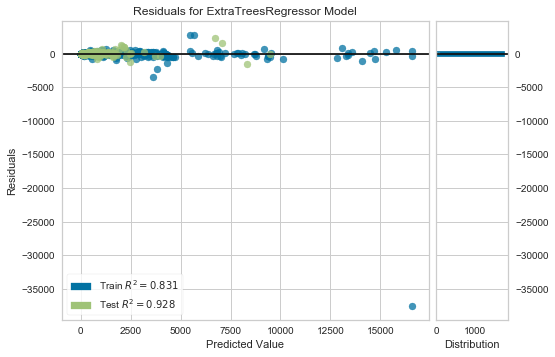

In [86]:
s = setup(data_train.reset_index(drop=True),
          target = t,
          test_data=data_test.reset_index(drop=True),
          data_split_shuffle = False,
          normalize=True,
          ignore_features = [target[(i+1)%2]],
          numeric_features = list(num_features),
          categorical_features = ['company'],
          silent = True, verbose = False, session_id = 123)

model = create_model(tuned_models[0])
# plot model
plot_model(model, plot = 'residuals')
plt.show()

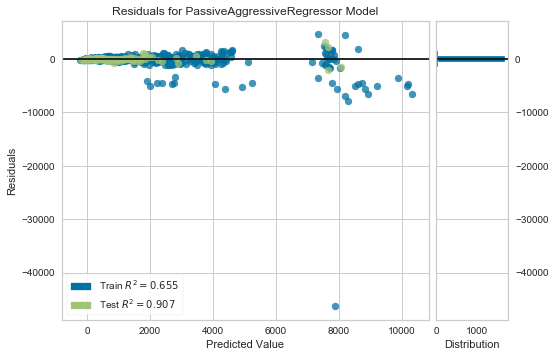

In [87]:
model = create_model(tuned_models[1])
# plot model
plot_model(model, plot = 'residuals')
plt.show()

We see that both predicted residuals are concentrated around zero.

### Prediction Error Plot

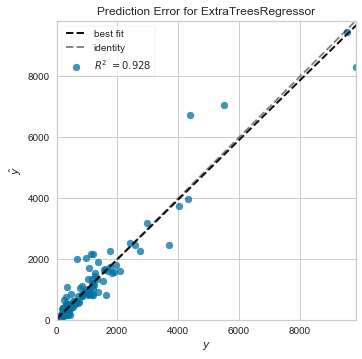

In [88]:
model = create_model(tuned_models[0])
# plot model
plot_model(model, plot = 'error')
plt.show()

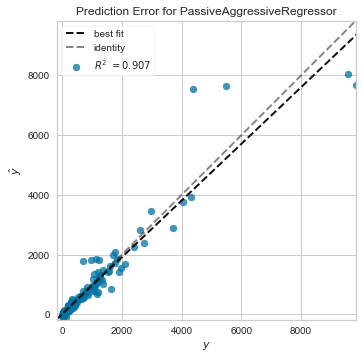

In [89]:
model = create_model(tuned_models[1])
# plot model
plot_model(model, plot = 'error')
plt.show()

### Feature importance

Let's consider top-10 most important features

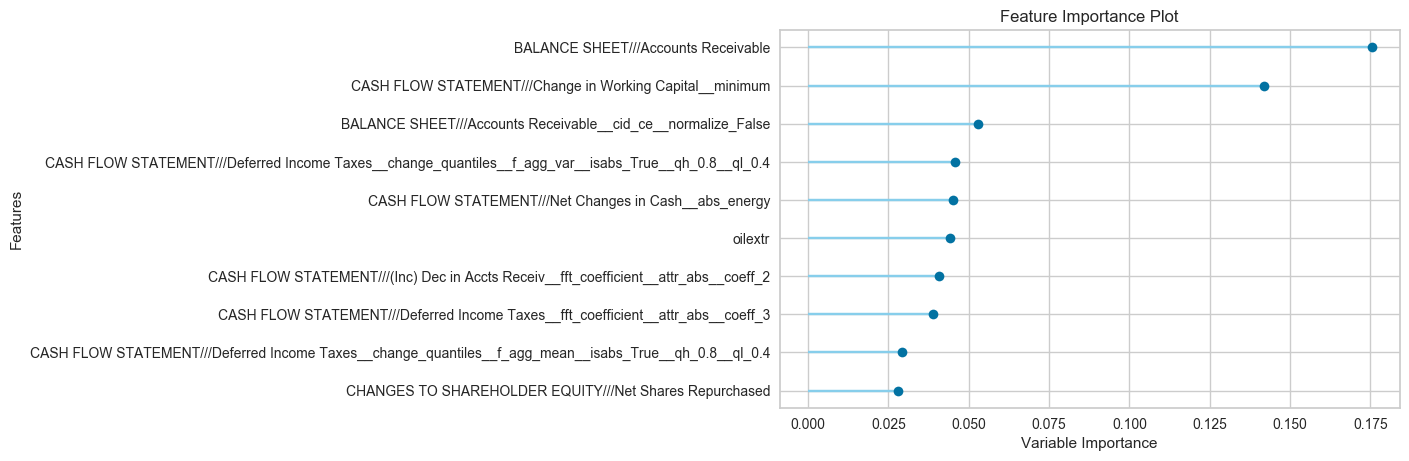

In [92]:
model = create_model(tuned_models[0])
# plot model
plot_model(model, plot = 'feature')
plt.show()

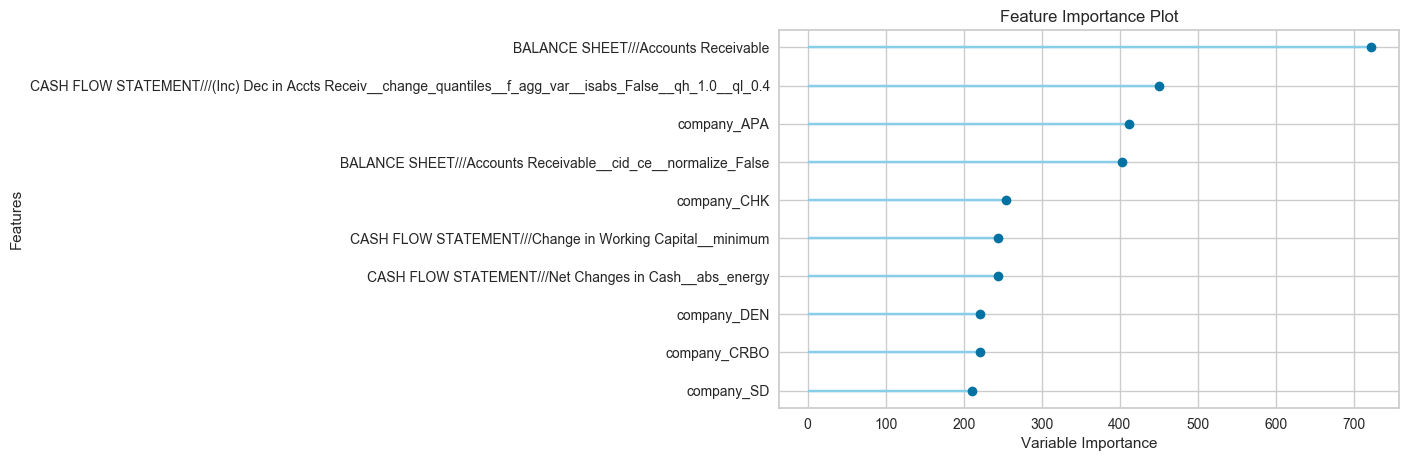

In [93]:
model = create_model(tuned_models[1])
# plot model
plot_model(model, plot = 'feature')
plt.show()